In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
import scipy.stats as stats
import math
import plot_tools as ptools

def Gauss(x, A, mu, sig):
    y = A*np.exp(-(x-mu)**2/(2*sig**2))
    return y


In [2]:
######## USER ##########

balanced = True
name_1 = 'SNII+HostXT_V19'
name_2 = 'SNIa-SALT2'

########################

features = [None, None]

for idx, method in enumerate(['bazin', 'mbf']):

    features_1 = pd.read_parquet(f'../data/features/{method}/{name_1}_features.parquet')
    features_1['target'] = name_1
    features_2 = pd.read_parquet(f'../data/features/{method}/{name_2}_features.parquet')
    features_2['target'] = name_2

    if balanced:
        nobj = min(len(features_1), len(features_2))
        features[idx] = pd.concat([features_1[:nobj], features_2[:nobj]])

    else:
        features[idx] = pd.concat([features_1, features_2])
    
# Remove unwanted columns
features[0].drop(columns={'nb_points_g', 'nb_points_r', 'nb_points_i'}, inplace=True)
features[1].drop(columns={'nb_points'}, inplace=True)
    
methods = [[features[0], 'bazin'], [features[1], 'mbf']]

# Predict the target

bazin : Accuracy on testing sample is : 98.54%
Efficiency : 98.62% of real SNII+HostXT_V19 were labeled as SNII+HostXT_V19
Purity : 98.47% of classified SNII+HostXT_V19 were indeed SNII+HostXT_V19


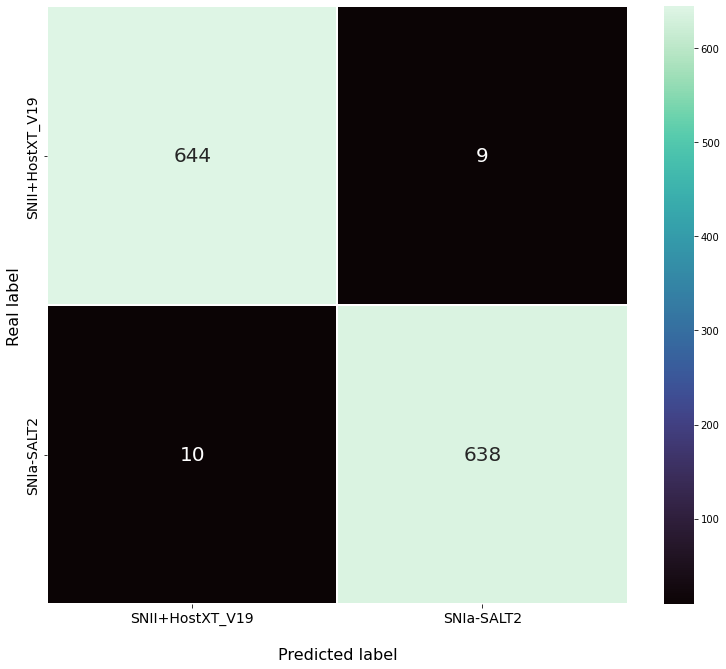

mbf : Accuracy on testing sample is : 97.39%
Efficiency : 96.94% of real SNII+HostXT_V19 were labeled as SNII+HostXT_V19
Purity : 97.84% of classified SNII+HostXT_V19 were indeed SNII+HostXT_V19


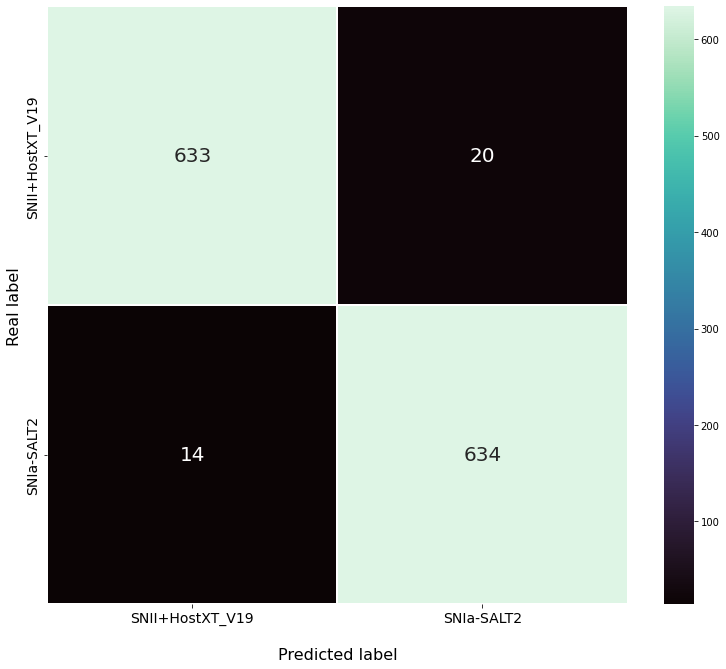

In [3]:
seed = 42

rf = {}

for method in methods:
    
    X_train, X_test, y_train, y_test = train_test_split(method[0].drop(columns={'target', 'true_peak'}), method[0]['target'], test_size=0.5, random_state=seed)
    clf = RandomForestClassifier(n_estimators = 100, random_state=seed)
    clf.fit(X_train, y_train)
    
    rf[method[1]] = clf

    score = clf.score(X_test, y_test)
    print(f'{method[1]} : Accuracy on testing sample is : {score*100:.2f}%')
    ptools.draw_confusion(clf, X_test, y_test, interest=name_1)

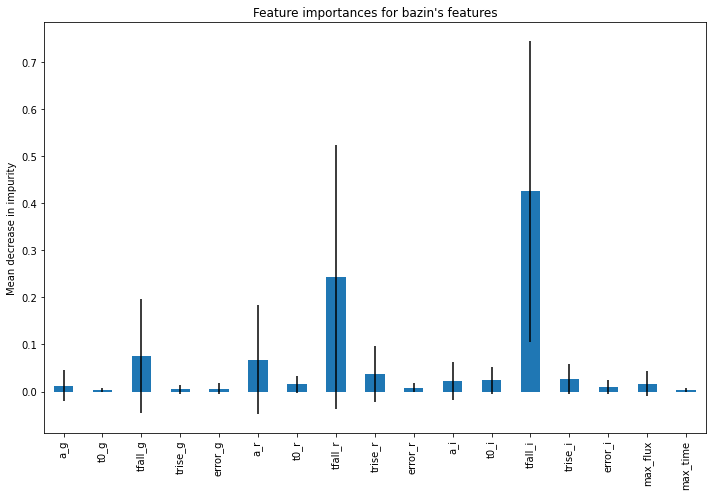

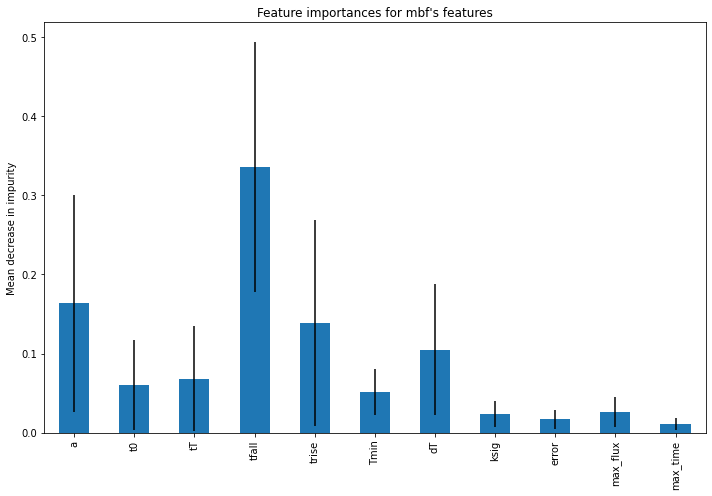

In [4]:
for idx, method in enumerate(methods):
    
    importances = rf[method[1]].feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf[method[1]].estimators_], axis=0)

    forest_importances = pd.Series(importances, index=method[0].drop(columns={'target', 'true_peak'}).keys())
    fig, ax = plt.subplots(figsize = (10, 7))


    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title(f"Feature importances for {method[1]}'s features")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

# Predict the max peak using machine learning

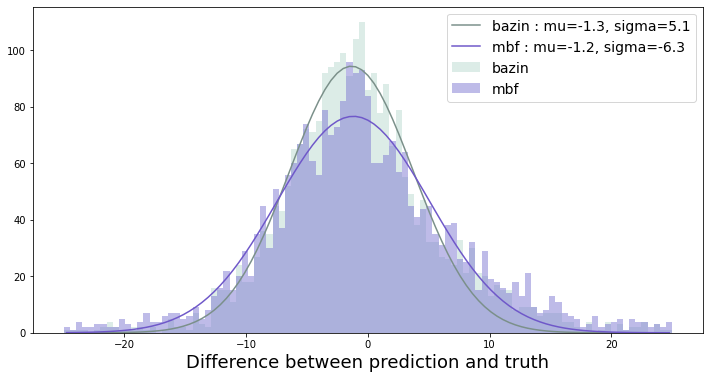

In [104]:
plt.figure(figsize =(12,6))
plt.xlabel("Difference between prediction and truth", fontsize = 18)

for method in methods:
    
    colors = ['#6F58C9', '#7E78D2']
    if method[1] == 'bazin':
        colors = ['#7B908A', '#BBDBD1']
    
    X = method[0].drop(columns={'target', 'true_peak'})
    y = method[0]['true_peak']
    reg = LinearRegression().fit(X, y)
    
    prediction = reg.predict(method[0].drop(columns={'target', 'true_peak'}))
    
    diff = prediction - y
    bins = np.linspace(-25, 25, 100)
    
    (n, b, patches) = plt.hist(diff, bins=bins, label=method[1], alpha=0.5, density=False, color=colors[1]);
    
    width = b[1] - b[0]
    center_bins = b[:-1]+(width/2)
    
    parameters, covariance = curve_fit(Gauss, center_bins, n)
    plt.plot(center_bins, Gauss(center_bins, *parameters), color=colors[0],\
             label=f"{method[1]} : mu={parameters[1]:.1f}, sigma={parameters[2]:.1f}") 

    
plt.legend(fontsize = 14)
plt.show()